# Peptide Retention Time Prediction using Decoder-Only Transformer – Training Notebook

This notebook trains a Decoder-Only Transformer model to predict peptide retention times from sequence.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')  # so we can import rt_transformer.py

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTDecoderModel, split_dataset, collate, run_epoch, compute_metrics

import torch
from torch import nn
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt

## 2. Configuration
Set data and saved model paths, model hyperparameters, and training settings.

In [ ]:
DATA_PATH = "data/misc_dia.txt"
MODEL_PATH = "models/rt_decoder_model_misc_dia_64_4_4_5.pt"

# Model config
BATCH_SIZE = 64
EPOCHS = 300
LEARNING_RATE = 3e-4
D_MODEL = 64
N_HEADS = 4
N_QUERIES = 4
N_LAYERS = 5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Using device: cuda


## 3. Data Preparation
Load the dataset, split into train/validation, and create DataLoaders.

In [3]:
# Initialize tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Split into train/val
train_ds, val_ds = split_dataset(dataset, val_ratio=0.05, seed=SEED)

# DataLoaders
coll = lambda b: collate(b, tokenizer.pad_id)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=coll)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=coll)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

Train samples: 139258, Val samples: 7329


## 4. Model Initialization
Create the Transformer model and optimizer.

In [4]:
model = PeptideRTDecoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.SmoothL1Loss()
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model size: 340034 parameters


## 5. Training Loop
Train the model and monitor loss.

In [5]:
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    train_loss = run_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss   = run_epoch(model, val_loader,   loss_fn, None, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.6f} | val loss {val_loss:.6f}")
    torch.save(model.state_dict(), MODEL_PATH)

Epoch   1 | train loss 2130.534952 | val loss 705.781033
Epoch   2 | train loss 553.795726 | val loss 450.437619
Epoch   3 | train loss 465.674489 | val loss 383.622908
Epoch   4 | train loss 445.597472 | val loss 369.056794
Epoch   5 | train loss 430.297929 | val loss 374.953826
Epoch   6 | train loss 422.876236 | val loss 348.528975
Epoch   7 | train loss 415.367157 | val loss 358.617380
Epoch   8 | train loss 411.478109 | val loss 344.799390
Epoch   9 | train loss 404.910363 | val loss 349.228343
Epoch  10 | train loss 400.741378 | val loss 349.756171
Epoch  11 | train loss 397.191931 | val loss 406.511815
Epoch  12 | train loss 393.950488 | val loss 324.747310
Epoch  13 | train loss 387.866728 | val loss 339.329067
Epoch  14 | train loss 386.849179 | val loss 321.614724
Epoch  15 | train loss 382.457108 | val loss 312.849234
Epoch  16 | train loss 380.589646 | val loss 313.291099
Epoch  17 | train loss 375.440426 | val loss 316.141336
Epoch  18 | train loss 373.972335 | val loss 31

## 6. Plot Training Curve

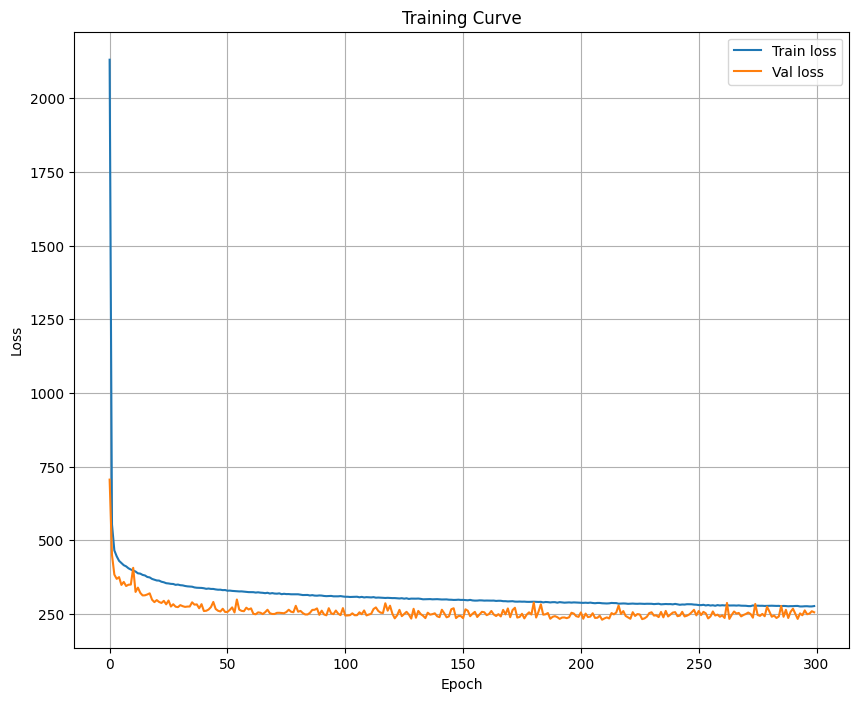

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curve')
plt.grid(True)
plt.show()

## 7. Compute Main Metrics for Trained Model

In [7]:
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for seqs, mask, rts in val_loader:
        seqs, mask, rts = seqs.to(DEVICE), mask.to(DEVICE), rts.to(DEVICE)
        preds = model(seqs, mask)
        all_preds.append(preds.cpu())
        all_trues.append(rts.cpu())
all_preds = torch.cat(all_preds)
all_trues = torch.cat(all_trues)

metrics = compute_metrics(all_preds, all_trues)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.5f}")



Validation metrics for model:
MAE       : 256.18127
MSE       : 127878.16406
RMSE      : 357.60056
Max_Abs_Error: 2845.72900
Median_Abs_Error: 188.68994
Mean_Abs_Percentage_Error: inf
Std_Error : 341.64120
Std_True  : 2751.13403
Std_Pred  : 2758.61597
R2        : 0.98310
Explained_Variance: 0.98458
Pearson   : 0.99231
Spearman  : 0.99429
